In [1]:
import numpy as np 
import tensorflow as tf 
from utilities import * 
from models import HMCModel, HMC_LSTM, CoherentLSTM
import matplotlib.pyplot as plt 
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [22]:
N = 200
data1 = generate_rectangular_data(3, 4, 2, 3, size=N)
data2 = generate_rectangular_data(6, 8, 4, 5, size=N)
data = np.concatenate([data1, data2])
y1 = np.array([0.0]*N + [1.0]*N)
y2 = np.array([1.0]*N + [0.0]*N)
y3 = np.ones([N*2,1])
y = np.concatenate([y1[:,np.newaxis], y2[:,np.newaxis], y3], axis=1)
structure = np.array([[0,0,1],[0,0,1],[0,0,0]])


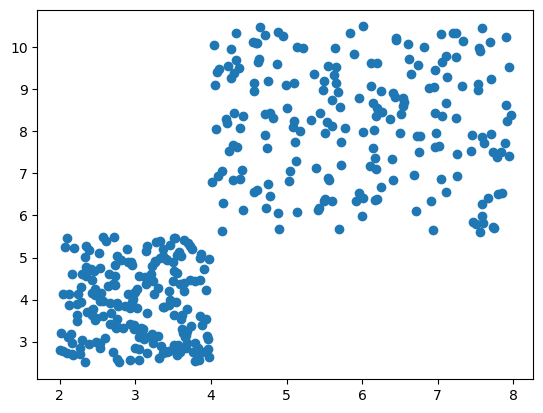

In [6]:
plt.scatter(data[:,0], data[:,1])

In [23]:
y

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       ...,
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.]])

In [24]:
idx = np.random.permutation(N*2)
train_num = int(2 * N * 6 / 10)
valid_num = int(2 * N * 2 / 10)
test_num = N * 2 - train_num - valid_num

train_idx = idx[:train_num]
valid_idx = idx[train_num:(train_num + valid_num)]
test_idx = idx[(train_num + valid_num):]

x_train, x_valid, x_test = data[train_idx], data[valid_idx], data[test_idx]
y_train, y_valid, y_test = y[train_idx], y[valid_idx], y[test_idx]

In [30]:
learning_rate = 1e-4
batch_size = 64
epochs = 100

model1 = HMCModel(
    structure=structure, 
    num_classes=3, 
    hid_dim_list=[10]
)
def get_train_step_fn(model, optimizer, loss_fn):
    def train_step_fn(x, y, validation_data=None):
        with tf.GradientTape() as tape:
            logits = model(x)
            logits = model.postprocess(logits)
            loss = loss_fn(y, logits)
            
            if validation_data is not None:
                valid_x = validation_data[0]
                valid_y = validation_data[1]
                valid_logits = model(valid_x)
                valid_logits = model.postprocess(valid_logits)
                valid_loss = loss_fn(valid_y, valid_logits)
            
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss, valid_loss 
    return train_step_fn

loss_fn = get_loss_fn_sigmoid()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_train_step_fn(model1, optimizer, loss_fn)

train_data = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(buffer_size = N*2).batch(batch_size=batch_size)

for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_data:
        loss, valid_loss = train_step_fn(
            x_train_batch, 
            y_train_batch, 
            (x_valid, y_valid)
        )
    if (epoch + 1) % 10 == 0:
        print("epoch {}/{}, loss {}, valid loss {}".format(epoch+1, epochs, loss, valid_loss))

epoch 10/100, loss 3.6772944927215576, valid loss 3.9471778869628906
epoch 20/100, loss 3.7603390216827393, valid loss 3.8639473915100098
epoch 30/100, loss 3.5070693492889404, valid loss 3.7904956340789795
epoch 40/100, loss 3.558793306350708, valid loss 3.7241930961608887
epoch 50/100, loss 3.6876070499420166, valid loss 3.6637654304504395
epoch 60/100, loss 3.6230075359344482, valid loss 3.607891798019409
epoch 70/100, loss 3.7726504802703857, valid loss 3.556373119354248
epoch 80/100, loss 3.3192386627197266, valid loss 3.507936477661133
epoch 90/100, loss 3.2813303470611572, valid loss 3.4622244834899902
epoch 100/100, loss 3.3393242359161377, valid loss 3.419265031814575


In [33]:
model1.get_prob(model1(data))

<tf.Tensor: shape=(400, 3), dtype=float32, numpy=
array([[0.3609013 , 0.3521053 , 0.78707886],
       [0.24542117, 0.42950144, 0.74923354],
       [0.3858133 , 0.31807876, 0.813834  ],
       ...,
       [0.07523887, 0.5324873 , 0.76191896],
       [0.28484434, 0.18270744, 0.9378617 ],
       [0.03642074, 0.49385437, 0.84653217]], dtype=float32)>